# Section III. MOTION PLANNING


# Chapter 12. Advanced Topics in Planning


Multi-goal planning
-------------------------


### Planning with goal sets

### Tours

### Coverage path planning

Multi-agent planning
--------------------

Computational complexity (NP hard on graph)

Deadlock

Coordination graph

Manipulation planning and locomotion planning
---------------------------------------------

Although at first glance, manipulation and locomotion may appear to be very different subjects, in many respects they are quite similar.  Because they both involve making and breaking contact with the environment, the dynamics of manipulation and locomotion are actually *dual* to one another -- in one case, the robot uses contact to move objects, while in the other, the robot uses contact to move itself!  From a planning perspective, they are not so different, and common techniques are needed for both of these settings to address the complication of contact.

The stereotype we have of robot manipulation is likely pick-and-place manipulation, in which a robot grasps an object to bring it to a desired location. This is indeed an practical and economically relevant task, used pervasively in factory and warehouse settings, but also in futuristic visions of service robots bringing us ice cold beverages on demand. It will serve as a model problem for discussing the primary issues involved in manipulation planning.  However, this is only the tip of the iceberg in terms of manipulation tasks, and we shall try to keep the discussion somewhat generalizable to other settings.  Furthermore, although manipulation and locomotion are duals of one another, the nuanced characteristics of each problem require somewhat specialized study.

At a high level, the contact problem brings up a critical issue that we have not yet addressed in the planning algorithms discussed so far: how should the robot choose when and where to make contact in order to achieve its goals?   The choice of contact is special compared to simply executing some motion, because at the moment that contact is made or broken, there is a discrete jump in the behavior of the robot-environment system -- for example, either the object is grasped and under the direct influence of the robot, or the object is free and the robot's movement doesn't affect it.  In the control and dynamics literature, this is also known as a *hybrid system*, in which the dynamics instantaneously jump at certain states.  For the purpose of planning, the states at which contact is made or broken are indeed special states that deserve focused attention. In an abstract sense, they are *narrow passages* that should be reasoned about carefully. (Is it likely that a random movement of your hands will pick up a pen?)  In order to properly solve these problems, a planner needs to perform simultaneous reasoning both at the level of contact choice as well as configuration-space motion; whether a contact choice can be executed by the robot depends on the reachability characteristics of configuration space, but motion choices are meaningless unless guided by the effects of contact. 

*******************************
<a href="#fig:Equilibrium"></a>

TODO

<div class="figcaption"><b>Figure 1</b>. 
    TODO: Illustrate the contact choice problem
    </div>

**********************************


We also need to develop specialized techniques for planning grasps for manipulators.  This is where we'll start our discussion.  We will also touch on the similar problems of planning placement locations for manipulated objects and footstep locations for legged robots.

### Grasp planning and placement planning

The role of a grasp planner is to generate high-quality candidate grasps, and at least one should yield a feasible completion of a manipulation action.  For the purposes of planning, we represent a grasp as follows:

> **Grasp**: a specification of a gripper's location and finger configuration (if applicable).
> For example, this could include a transform $T_g$ of the gripper base and a configuration $q_f$
> of the gripper's fingers.  The specification may include other tasks, such as a rotation constraint about an axis, or auxiliary data, such as the intended contact points or grip strength.

It is important to note two things about a grasp. First, *this specification is independent of the rest of the robot*.  This allows us to reason about the gripper in isolation rather than concerning ourselves with reachability and paths.  Second, much like a configuration doesn't need to refer to a feasible configuration, *the specification does not imply that an object will be successfully picked up*.  Rather, our planner will generate possible grasps and predict whether they will be successful.

To achieve a high-quality grasp, its contact points must be chosen carefully to accomplish the desired task. Contact is not only essential for grasping but for many other interesting tasks in robotics, including pushing, in-hand manipulation, stacking objects, driving wheeled robots at speed, and legged locomotion.  So let's dive into how to mathematically and computationally reason about contact.


#### Contact modeling

At a microscopic level, contact is a complex phenomon involving deformation, surface roughness, and intermolecular forces like adhesion.  On the other hand, at the macroscopic level, contact between rigid objects can be modeled in a fairly simple fashion: the objects do not interpenetrate, and forces result when they touch.  For computational purposes, we usually model contact as a collection of *point contacts* with various constraints on how they apply forces ([Fig. 2](#fig:Contact)).  Although in physics simulation we will treat contacts as existing only at a moment in time, in this chapter we will consider persistent contact and how they affect the range of possible motions of an object.

*******************************
<a href="#fig:Contact"></a>

![#fig:Contact](figures/modeling/contact.svg)

<div class="figcaption"><b>Figure 2</b>. 
    Although contact consists of many microscopic interactions over a continuous area (left), it can be modeled relatively accurately as a finite set of contact points, in this case, two points with Coulomb friction (right).
    </div>

**********************************

A **frictionless point contact** between objects $A$ and $B$ consists of a point $\mathbf{p}$ and a normal $\mathbf{n}$. A typical convention is that $\mathbf{n}$ points from $A$ toward $B$.  The contact force $f$ yields a force vector $\mathbf{f} = f\mathbf{n}$ which is applied to $A$, and the negative force $-\mathbf{f}$ is applied to $B$. 

$f$ must satisfy a {\em unilateral constraint} $f\geq 0$.  Moreover, to avoid further penetration, the post-contact velocities of the objects must be such that $(\mathbf{p}_B - \mathbf{p}_A)^T \mathbf{n} \geq 0$, where $\mathbf{p}_A$ is the contact point as though it were attached to $A$, and $\mathbf{p}_B$ is the contact point as though it were attached to $B$.

A **Coulomb friction model** makes the assumption that the component of the contact force orthogonal to the normal is bounded by a constant times the force in the normal direction.  Specifically, let $f_\parallel = \mathbf{n}^T \mathbf{f}$ be the normal component of the force.  The orthogonal component of the force is $\mathbf{f}_\perp = \mathbf{f} - f_\parallel \mathbf{n}$.  The Coulomb model states that:

$$ \| \mathbf{f}_\perp \| \leq \mu f_\parallel $$

with $\mu \geq 0$ the friction coefficient between the two surfaces.  A frictionless contact is equivalent to $\mu=0$, with the additional condition that $f_\parallel\geq 0$.  (Note that if $\mu > 0$, then this unilateral inequality is also implied by the Coulomb inequality.) Slippery surfaces like ice will have $\mu < 0.1$, while high friction surfaces like rubber on rubber will have coefficients $\mu > 1$.  The shape of valid forces is a *friction cone* with apex at the origin and the opening pointing in direction $\mathbf{n}$.  The angle between the axis of the cone and its side is $\tan^{-1} \mu$.

A force on an object induces a **torque** about its center of mass $\mathbf{c}$.  In 3D, the torque $\tau$ is a vector formed by the cross product of the moment arm $\mathbf{p}-\mathbf{c}$ and the force: $\tau = (\mathbf{p}-\mathbf{c}) \times \mathbf{f}$.

The combined force and a torque is called a **wrench** $\mathbf{w}=(\mathbf{f},\mathbf{\tau})$. In 2D, a wrench is a 3D vector, and in 3D, it is a 6D vector.

To **model a planar polygonal contact patch** with uniform friction, we can place a single contact point at each vertex.  This arrangement is equivalent to placing contact points along edges or in the center of the patch because the set of possible *net wrenches* are equivalent.  Specifically, let $P$ be the contact patch, with normal $\mathbf{n}$.  Let $\mathbf{v}_1,\ldots,\mathbf{v}_m$ by its vertices.  If $\mathbf{w}$ is a net wrench generated by valid forces $\mathbf{f}_1\ldots,\mathbf{f}_N$ applied any set of contact points $\mathbf{p}_1,\ldots,\mathbf{p}_N$ taken from $P$, then we can also find a set of valid forces $\mathbf{f}_1^\prime,...,\mathbf{f}_m^\prime$ at $\mathbf{v}_1,\ldots,\mathbf{v}_m$, respectively, that generate $\mathbf{w}$ as the net wrench.

#### Equilibrium conditions

Suppose an object O at rest is in contact with a fixed environment at a set of Coulomb point contacts $(\mathbf{p}_1,\mathbf{n}_1,\mu_1),\ldots,(\mathbf{p}_M,\mathbf{n}_M,\mu_M)$.  In order for it to stay in *static equilibrium* (i.e., balanced), there must exist valid forces $\mathbf{f}_1,\ldots,\mathbf{f}_M$ at the contacts such that several conditions are simultaneously satisfied:

* Force balance: $\sum_{i=1}^M \mathbf{f}_i + m\mathbf{g} = 0$ where $m$ is O's mass and $\mathbf{g}$ is the gravity vector (usually taken to be (0,0,-9.81$m/s^2$)).
* Torque balance: $\sum_{i=1}^M (\mathbf{p}_i - \mathbf{c})\times \mathbf{f}_i = 0$, where $\mathbf{c}$ is O's center of mass.
* Coulomb friction: $\| \mathbf{f}_{i,\perp} \| \leq \mu_i f_{i,\parallel}$, $f_{i,\parallel} \geq 0$.  Here we have defined $f_{i,\parallel} = \mathbf{f}_i^T \mathbf{n}_i$ and $\mathbf{f}_{i,\perp} = \mathbf{f}_i - f_{i,\parallel}\mathbf{n}_i$.

If it is known that the surface is horizontal, the solution to these equations gives the well-known *support polygon* solution.

> **Support polygon**: the convex hull of the contact points, projected onto the horizontal plane.

The object will be in stable equilibrium if the projection of the center of mass onto the plane lies within the support polygon, and the object will not be in equilibrium otherwise. 

*******************************
<a href="#fig:Equilibrium"></a>

| (a) Static equilibrium  | (b) Support polygon  |
|---------------------------------------------------------------|-----------------------------------------------------|
| ![fig:EquilibriumTest](figures/modeling/stability.svg) | ![fig:SupportPolygon](figures/modeling/support_polygon.svg) |

<div class="figcaption"><b>Figure 3</b>.  Static equilibrium is obtained when (valid) contact forces and torques are in balance with gravity.  For planar contact, the solution set is described by the support polygon.  The object is in equilibrium when its center of mass lies directly over (or under) the support polygon.
    </div>

**********************************

In the more general case, we can solve a convex constrained optimization problem to determine whether there exist a set of forces that meet these conditions.  However, in 3D, the Coulomb friction constraint is nonlinear and requires solving a Second Order Cone Program (SOCP), which is a relatively specialized form of optimization problem. It is common to approximate the SOCP as a [Linear Program](Optimization.ipynb#Linear-and-quadratic-programming) (LP) which can be solved more quickly, more reliably, and with greater availability in scientific computing packages.  The *polyhedral friction cone approximation* linearizes the friction cone constraints so that the static equilibrium test can be formulated directly as an LP. 

**************************
<a href="#fig:PolyhedralFrictionCone"></a>

| (a) 2D friction cones are (unbounded) polyhedra | (b) 3D friction cones can be approximated using a polyhedral approximation  |
|---------------------------------------------------------------|-----------------------------------------------------|
| ![#fig:PolyhedralFrictionCone2D](figures/modeling/friction_cones_2d.svg) | ![#fig:PolyhedralFrictionCone3D](figures/modeling/friction_cones_3d.svg)  |


<div class="figcaption"><b>Figure 4</b>. 
    Friction cones can be represented either by a collection of frictionless point contacts or a set of halfplane constraints $B \mathcal{f} \leq 0$.
    </div>



**************************

To construct such an approximation, first create two vectors $\mathbf{s}$ and $\mathbf{t}$ that are orthogonal to one another and to $\mathbf{n}$.  Moreover, ensure that $\mathbf{s},\mathbf{t},\mathbf{n}$ form the basis of a right-handed coordinate system, with $\mathbf{n}$ in the Z direction.  Now, the boundary of the friction cone is formed by rays in the directions $\mathbf{n}+\mu (\mathbf{s} \cos \theta + \mathbf{t} \sin \theta)$, with $\theta\in [0,2\pi)$.  We can simply sample some of these values of $\theta$ to create a sampling of edges $\mathbf{r}_j$, $j=1,...,k$ of the polygonalized cone ([Fig. 4.b](#fig:PolyhedralFrictionCone)). By taking the cross-product between subsequent rays, we obtain the inward normal of a face of the cone, and then by negation we can establish each of the rows of a $k \times 3$ matrix $B$.

With each linearized friction cone constraint expressed as an inequality $B_i \mathbf{f}_i \leq 0$ (inequality taken element-wise), the LP constraints are:

$$
\begin{aligned}
\begin{bmatrix}
I & I & \cdots & I \\
[\mathbf{p}_1-\mathbf{c}] & [\mathbf{p}_2-\mathbf{c}] & \cdots & [\mathbf{p}_M-\mathbf{c}]
\end{bmatrix}
\begin{bmatrix}
\mathbf{f}_1 \\ \vdots \\ \mathbf{f}_M
\end{bmatrix}
 &= \begin{bmatrix} -m\mathbf{g} \\ 0 \end{bmatrix}  \\
 B_1 \mathbf{f}_1 &\leq 0   \\
\vdots & \\
B_M \mathbf{f}_M &\leq 0 
\end{aligned}
$$

By employing these constraints on the force variables, an LP solver can test for equilibrium within milliseconds for dozens of contact points. 


#### Grasp robustness

When choosing grasps or placement locations for objects, it is important to analyze how robust they are to disturbances.  We will look briefly at a few concepts that are widely used in robotics for scoring or generating robust grasps.

The $6\times 3M$ matrix in the equality constraint of the LP given above:
$$
\begin{bmatrix}
I & I & \cdots & I \\
[\mathbf{p}_1-\mathbf{c}] & [\mathbf{p}_2-\mathbf{c}] & \cdots & [\mathbf{p}_M-\mathbf{c}]
\end{bmatrix}
$$
is used so frequently in grasp and stability computations that it is given a special name: the *grasp matrix* $G$.  Its significance is that it converts forces at contacts to wrenches on the object.  Moreover, if we multiply a velocity $\mathbf{v}$ and angular velocity $\mathbf{\omega}$ about the center of mass by $G^T$, we get a vector of stacked contact point velocities:

$$
\begin{bmatrix}\dot{\mathbf{p}}_1 \\ \vdots \\ \dot{\mathbf{p}}_M \end{bmatrix}
= G^T \begin{bmatrix}\mathbf{v} \\ \mathbf{\omega} \end{bmatrix}
$$
describing the velocity of each of the contact points, as though the point were attached to $O$ as it moved at the given velocities.

We can use this to define a notion called **form closure** that characterizes the quality of an immobilizing grasp.  In particular, a set of contacts establishes form closure on O if every possible nonzero velocity and angular velocity yield increasing interpenetration of the contact points ([Fig. 5](#fig:FormClosure)).  Specifically, form closure states that for every $(\mathbf{v},\mathbf{\omega})\neq 0$,  the induced normal velocity of at least one contact point is negative: that is, $\mathbf{n}_i^T \dot{\mathbf{p}}_i < 0$.  (We are referring to the most usually discussed type of form closure, which is known as first-order form closure.)  If we define an $M \times 3M$ *normal matrix* consisting of a block-diagonal set of normal vectors:

$$N = \begin{bmatrix} 
\mathbf{n}_1   &   &   &  \\
    & \mathbf{n}_2 &   &  \\
    &    & \ddots  &  \\
    &    &      & \mathbf{n}_M
\end{bmatrix}
$$

then the vector of contact point velocities in the normal directions is given by $N^T G^T \begin{bmatrix} \mathbf{v} \\ \mathbf{\omega} \end{bmatrix}$.  Succinctly, form closure states that $N^T G^T \mathbf{x} \geq 0 \implies \mathbf{x}=0$.  Like equilibrium, this can be tested using a LP.

*******************************
<a href="#fig:FormClosure"></a>

| (a) Two objects in form closure  | (b) Two objects not in form closure |
|---------------------------------------------------------------|-----------------------------------------------------|
| ![#fig:FormClosure](figures/modeling/form_closure.svg) | ![#fig:FormClosure](figures/modeling/not_form_closure.svg)  |

<div class="figcaption"><b>Figure 5</b>. 
    Form closure of a set of point contacts indicates that the object is immobilized because any movement would induce interpenetration.
    </div>

**********************************


Another related notion is that of **force closure**.  Force closure is established by a set of contacts if for *any* external wrench $\mathbf{w}_{ext}$, there exists a set of forces $\mathbf{f}_1,\ldots,\mathbf{f}_N$ that counteracts it.  It is highly correlated with what we consider a *prehensile* grasp, in that an object in force closure is surely grasped: it will resist forces in every direction, and if the gripper is strong enough, the object can be reoriented to  any orientation without escape.  On the other hand, if a grasp is not in force closure, there is some direction in which the object can be pulled or twisted to escape the grasp.

To determine whether an object is in force closure, let $\mathbf{f}$ be the stacked vector of forces. Using a polygonal approximation to the friction cone, can express this condition as $G \mathbf{f} = \mathbf{w}_{ext}$, $B \mathbf{f} \leq 0$ with $B$ the block-diagonal matrix of friction cone constraints.  In other words, for all $\mathbf{f}$ satisfying $B \mathbf{f} \leq 0$, $G \mathbf{f}$ spans the entire 6D space.  (Note that force closure is an idealized model that assumes that the contacts can apply an unbounded force; in reality, every fixture has its breaking point.)

The constraint $B \mathbf{f} \leq 0$ is known as a cone constraint, because if any vector $\mathbf{f}$ satisfies it, then so does $c\mathbf{f}$ with $c \geq 0$.  A linear transform of a cone is also a cone, so the wrench space $W = \{ G \mathbf{f} \,|\, B \mathbf{f} \leq 0 \}$ is also a cone.  To see if $W$ is equal to $\mathbb{R}^6$, we can simply check whether it contains the origin in its interior.  There are a few ways to do this, but one simple method is to maximize $\mathbf{w}_{ext}$ along rays emanating from the origin, using a set of rays whose convex hull contains the origin in its interior -- for example, each of the 6 primary axes and their negatives. If all of the rays have a nonzero maximum, then the object is in force closure.

It has been proven that form closure implies force closure, and that force closure with frictionless constraints implies form closure.  But for frictional contact, form closure is a stronger condition than force closure.

A weaker notion than form and force closure is the notion of a **caging grasp**, which is a set of point contacts do not allow the object to "escape" (i.e., move to a faraway pose) without penetrating at least one of the contacts. This type of grasp is still quite robust even though it does not necessarily immobilize the object. What is particulary intriguing about caging grasps is that verifying that a grasp cages an object is the negation of the motion planning problem: we need to prove that there is no collision-free path between the object's pose and a faraway pose.  In essence, we either need a complete motion planner or to accept some likelihood of incorrectly labeling a grasp as caging.  There are efficient complete caging grasp planners for simplified cases, such as 2D polygonal objects grasped by two point fingers, but the general case remains a challenging problem.

#### Grippers and grasp selection

A robot must consider several factors when choosing a grasp:

1. Will the grasp stably lift the object?
2. Will the grasp remain stable throughout the transfer motion?  (Grasping an object at its extremities may cause it to rotate, for example.)
2. Will the grasp acquisition process place the object in the intended relative pose?  (An off-center or misaligned grasp might disturb the object while the gripper's fingers are closing.)
4. Will the gripper be clear of obstacles in the environment while acquiring the grasp?
5. Can the robot reach the grasping pose with a feasible configuration?
6. Will the robot be able to carry out subsequent tasks with the grasp?

It is typical to adopt an *object-centric* strategy, which generates a first round of grasp candidates primarily considering factors 1-3, which only involve the object's shape and the physics of contact.  Next, to address factor 4, we may filter out grasps that would place the gripper into collision with objects in the environment.  Finally, we can address factor 5 via sampling and inverse kinematics, and we delay the consideration of future tasks in factor 6 to later stages of the motion planner.

A *grasp database* approach is a common object-centric strategy, in which high-qulity grasp candidates for an object are defined in its local frame during a precomputation step, and these candidates are reused during execution when the object's actual pose is observed.  It is worth the expense to generate high-quality grasps for a database of objects if it is known that the robot will be manipulating one of these objects during run time, for example, in industrial settings.  This approach is especially helpful if prehensile grasps are available, so that object orientation through the transfer motion no longer becomes a major consideration.   

For tool-use, it is important to consider factor 6 early in grasp selection.  For example, to pour water from a kettle it should be held by its handle rather than its spout, and to hammer a nail the hammer should be grabbed at its handle rather than its head.  Such a strategy is known as *task-centric* grasp selection.  Task-centric grasps are usually defined via human programming or demonstration, and such example grasps can be stored in a grasp database.

Although grasp databases are quite versatile, in many settings we must generate grasps for never-before-seen objects, and in other settings the problem of object pose recognition is very challenging.  In such settings we must produce grasps directly by reasoning with the object and scene geometry.  To do so, a [generate-and-score approach](WhatIsMotionPlanning.ipynb#Generate-and-score) is often used.  The grasp generation process can sample grasps uniformly in a grid, or at random, or with a distribution focused on locations and orientations that have a high likelihood of achieving a high score.  The grasp scoring process then evaluates multiple criteria and selects the $k$ grasps with highest score.  Below we discuss some common grasp generation and scoring criteria for different types of grippers.


*******************************
<a href="#fig:Grippers"></a>

TODO

<div class="figcaption"><b>Figure 6</b>. 
    TODO: Show types of gripper
    </div>

**********************************


**Suction grippers**. Suction grippers operate by a vacuum pump causing the object to be pressed against the vacuum seal by atmospheric pressure.  For these grippers, the grasp planning process primary requires identifying flat areas on the object that are fairly horizontal and roughly aligned to the object's center of mass.  The flatness criterion is needed to get a secure vacuum seal; on irregular surfaces the vaccuum effectiveness will be compromised.  The horizontal criterion is needed to avoid the object shearing sideways off of the vacuum seal.  Finally, the center of mass condition prevents unbalanced torques twisting the object off of the vacuum seal.  The relative importance of these factors depends on the mass and dimensions of the object, with lighter objects much easier to pick up and move in a prehensile fashion. (Note that for heavier objects, we ought to preserve a roughly horizonal orientation of the gripper, so we should modify transfer path planning constraints such that the orientation of the gripper is close to vertical. )

Generating candidate suction grasps is straightforward, because there are no fingers to concern ourselves with, the orientation of about a cylindrical vacuum about its primary axis has neglible effect on grasping, and moreover it is most effective to align the primary axis with the object's normal direction at the target contact point. So, we can simply sample points on the object's surface and align the vacuum to the object normal at each point.  This yields a 2D grasp configuration space, which can be sampled quite densely within a few hundreds of grasps. 

**Parallel-jaw grippers**. For parallel-jaw grippers, the *antipodal grasp* strategy tries to identify two locations on an object's surface that form opposing planes that can be grasped by the opposing jaws ([Fig. 6](#fig:antipodal_grasps)).  In other words, if we draw a line through the two points, then the line is aligned with the normals of the object's geometry at those points.  If the planes are not opposing, then the object has a higher likelihood of slipping out of the jaws during grasping or transfer.  If the object is grasped at parallel planes, the grasp's resistance to translational force is equal to $2 \mu f_{grip}$, twice the product of the grip force $f_{grip}$ and the friction coefficient $\mu$ between the object and the fingers.  The load limit is reduced if the normals are not parallel.

We also require *geometric compatibility* with the gripper: the object should be narrow enough to be grasped by the gripper's span, the points should not be deeper than the opening of the gripper, and there must be sufficient clearance around the points so that the fingers can be successfuly placed there.  Geometric compatibility can be verified via collision-checking or by examining the profile of the object along a plane through the antipodal grasp.

Another concern is the torque that is applied by gravity if the object is grasped off-center.   Let $d$ be the horizonal distance between the object's center of mass and the line through the points of contact. (By horizontal, we mean to project the center of mass and the two points onto a plane, and then take the distance in the plane.)  The torque applied by the force of gravity about the points of contact is $mgd$, where $m$ is the object's mass and $g$ is the gravitational constant $g \approx 9.81$m/s$^2$.  If this exceeds the frictional resistance to twisting imposed by the fingers, then the object will rotate.  Hence, it is advantageous to lift the object at points close to the center of mass, especially when the object is heavy ($m$ is large) or when the area of the contact patch at the points of contact are low (the frictional resistance to twisting is small).

*************
<a name="fig:antipodal_grasps"></a>

![fig:antipodal_grasp_planning](figures/planning/antipodal_grasp_planning.png)

<div class="figcaption"><b>Figure 7</b>. For parallel-jaw grippers, an antipodal grasp planner seeks locations on protruding areas of an object that are relatively flat, parallel, and opposed.  This point-cloud-based planner generates a number of candidates, shown as parallel green boxes indicating desired finger locations.
    </div>

*************

If an object is non-convex, then it is also advantageous to place the fingers at local minima of the object's width.  That is, if the fingers were to be perturbed slightly, then the gripper would need to open wider. This strategy means that local errors will actually increase the grip force rather than cause the grasp to break.

Antipodal grasp generation can be a bit more complex than suction grippers. If we consider all possible approach orientations and gripper widths, this leaves a 7D grasp configuration space. A common top-down grasping restriction enforces that the gripper should approach the object from a top-down orientation.  In this case, the 4D grasp configuration space consists only of the surface point, the orientation of the gripper about the Z axis, and the gripper width.

**Grasp generation and analysis for multifingered hands**. For multifingered hands, grasp planning can be considerably more complex than for suction and parallel-jaw grippers. First of all, the configuration space of a hand has $6+n$ dimensions, where the first 6 DOFs are the gripper base transform and $n$ is the number of finger DOFs. For anthropomorphic hands, $n$ can be as high as 20.  Second, the set of configurations that actually touch the object in a meaningful way is tiny compared to the set of useful configurations.  It is no wonder, then, that this is still an active topic of research.

One class of *approach-and-close* techniques focuses on making grasp sampling far more likely to find a reasonable grasp.  Under the assumption that there is a general canonical geometry of a gripper, containing a "center" of a gripper into which the object should fit, and an "approach direction" that allows the object to pass between the fingers toward the gripper center. The idea is then to sample approach directions to ensure that the object is likely to be within the gripper's fingers.  The grasp center is sampled within the object's volume, and then an approach direction is sampled at random.  A pose of the gripper that aligns the local approach direction with the sampled direction is chosen, and the translation is set to the match the local center with the sampled center.  If this pose causes the gripper to collide with the object, the gripper is backed out along the negative approach direction until the gripper is collision free.  Then, the fingers are incrementally closed until the finger links make contact.  Although there is a high likelihood of generating bogus grasps, particularly for objects with intricate or complex geometry, the likelihood of success is high enough for many objects that a reasonable grasp will be found within hundreds of samples.  There are also heuristics that can be used for long objects that chooses the gripper orientation to align an opening direction with the long axis of the object, which can also boost success rates.8

*************
<a name="fig:MultifingerGraspPlanning"></a>

TODO: Multifinger grasp planning

<div class="figcaption"><b>Figure 8</b>. 
    </div>

*************

A *geometric primitive approach* takes a similar approach to this heuristic.  If a novel object can be approximated by geometric primitives like boxes, spheres, and cylinders, then *template grasps* specialized to each primitive can be generated for the object. For example, suppose the gripper has a cylindrical power grasp mode in which the cylinder axis is aligned with gripper direction $d_{cyl}^G$, and we have determined relationships $c_{cyl}^G(r)$ and $q_f(r)$ between the cylinder radius $r$ and the cylinder center (relative to the gripper) and the finger opening configuration, respectively. Suppose we also observe that a part of the object is similar to a cylinder with center $c$, axis $d$, height $h$, and radius $r$.  Then, a grasp that takes on a transform $T_G$ placing $T_G d_{cyl}^G = d$ and $T_G c_{cyl}^G(r) = c + u d$ with $u\in[-h/2,h/2]$, while placing its fingers in configuration $q_f(r)$, will wrap around the observed cylinder. Note that there are two degrees of freedom, one the amount $u$ that the gripper slides along the cylinder, and another $\theta$ that determines the gripper orientation about the cylinder axis.  With such a grasp sampled, it remains to perform collision checking and other grasp quality assessments.

To score multifinger grasps, a variety of *grasp metrics* have been proposed.  Force closure is often a desirable property which can be tested using the methods [described above](#Grasp-robustness).  Other metrics use the concept of the *bounded wrench space* which is much like the wrench space defined above, except that the force magnitudes are bounded. Again, with $G$ the grasp matrix, we define a bounded wrench space

$$W_b \equiv \{ G\mathbf{f} \| \mathbf{f}_i \in FC_i, \mathbf{f}_i^T \mathbf{n}_i \leq 1\}.$$

Here we have bounded each force along its normal direction to be at most 1. There are other types of bounds, such as nonuniform bounds, finger-specific bounds, bounds on the sum of forces, etc.  In any case, assuming a polyhedral friction cone each of these bound types can be represented by the constraints $B\mathbf{f} \leq 0$, $C\mathbf{f}\leq 0$ with $C$ some matrix, and hence $W_b$ is a bounded polytope (3D for a 2D workspace, and 6D for a 3D workspace).  We can now try to characterize the quality of the grasp by the shape of $W_b$.  We describe three such quality metrics (of many):

- $Q_{vol}$: the volume of $W_b$.  Assigns higher scores to grasps that can resist a wide range of disturbance wrenches.
- $Q_{iso}$: the isometry of $W_b$.  Assigns higher scores to grasps that are not significantly weaker in one direction compared to another.
- $Q_{1}$: the maximum radius of a sphere centered at the origin inscribed inside $W_b$. Assigns higher scores to grasps that are not weak in any direction. 

*************
<a name="fig:GraspQuality"></a>

![fig:GraspQuality](figures/modeling/grasp_metrics.svg)

<div class="figcaption"><b>Figure 9</b>. Illustrating three grasp quality metrics based on the bounded wrench space.
    </div>

*************

To calculate $W_b$, we first compute the rays $\mathbf{r}_j$ bounding the polyhedral friction cone of each contact $i$, bounded to have magnitude 1 in the normal direction.  Then, we find the convex hull of the wrenches $(\mathbf{r}_j,\mathbf{p}_i-\mathbf{c})$ that result from the unit force along each of these ray, along with the zero wrench.  $W_b$ is the volume bounded by the convex hull, as shown below. The convex hull operation can be somewhat computationally expensive in 6D, but there are software packages to compute it (notably, [Qhull](http://qhull.org) which is used by Matlab and Scipy).  We are interested in both the vertices of $W_b$ and its faces.  

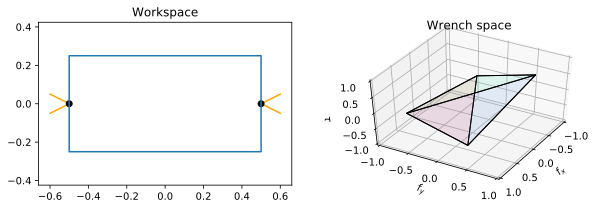

Qvol:0.333333, Qiso:0.190476, Q1:0.218218


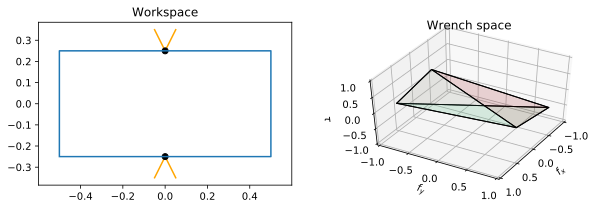

Qvol:0.166667, Qiso:0.107010, Q1:0.120386


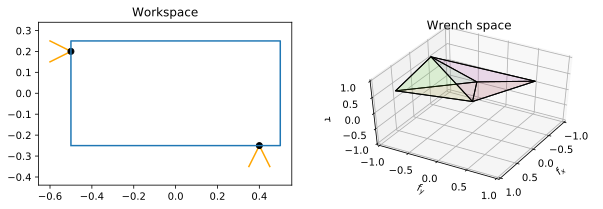

Qvol:0.337500, Qiso:-0.000000, Q1:-0.000000


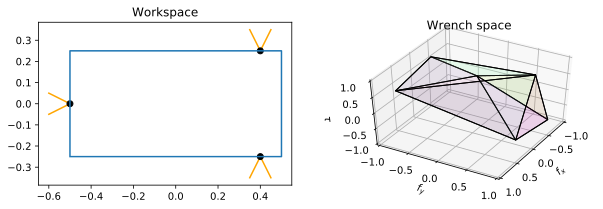

Qvol:0.770833, Qiso:0.097842, Q1:0.120851


In [3]:
# Code to visualize a 2D wrench space
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from klampt.math import so3,vectorops
from klampt.model.contact import ContactPoint
from scipy.spatial import ConvexHull
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors

def wrench_space_hull_2d(cps,origin=None,bound=1):
    """Computes the ConvexHull of the bounded wrench space for a
    2D set of contact points. 
    
    Torques are taken about the origin point or (0,0) if origin = None.
    
    Force bounds are given by bound, which can be a scalar or a
    list the same length as cps.
    """
    if origin is None:
        origin = (0,0)
    if not hasattr(bound,'__iter__'):
        bound = [bound]*len(cps)
    G = np.zeros((3,len(cps)*2+1))
    for i,cp in enumerate(cps):
        tang = [-cp.n[1],cp.n[0]]
        ray1 = vectorops.madd(cp.n[:2],tang,cp.kFriction)
        ray2 = vectorops.madd(cp.n[:2],tang,-cp.kFriction)
        ray1 = vectorops.mul(ray1,bound[i])
        ray2 = vectorops.mul(ray2,bound[i])
        G[:2,i*2] = ray1
        G[2,i*2] = vectorops.cross(ray1,vectorops.sub(cp.x[:2],origin))
        G[:2,i*2+1] = ray2
        G[2,i*2+1] = vectorops.cross(ray2,vectorops.sub(cp.x[:2],origin))
    return ConvexHull(G.T)

def wrench_space_metrics(hull):
    """Computes a dict from metric names to values."""
    sumvolume = 0
    for f in hull.simplices:
        sumvolume += abs(np.linalg.det(hull.points[f]))
    sumvolume /= np.math.factorial(hull.points.shape[1])
    #assume normals are unit
    offsets = -hull.equations[:,-1]
    minrad = min(offsets)
    maxrad = max(np.linalg.norm(p) for p in hull.points)
    if maxrad == 0:
        iso = 1
    else:
        iso = minrad/maxrad
    return {'Qvol':sumvolume,'Qiso':iso,'Q1':minrad}

def doplot(obj_vertices,contact_points):
    hull = wrench_space_hull_2d(contact_points)
    metrics = wrench_space_metrics(hull)
    verts = hull.points
    faces = hull.simplices

    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(1, 2, 1)
    poly = np.array(obj_vertices+[obj_vertices[0]])
    ax.plot(poly[:,0],poly[:,1])
    ax.scatter([cp.x[0] for cp in contact_points],[cp.x[1] for cp in contact_points],color='k')
    for cp in contact_points:
        x = cp.x
        tang = [-cp.n[1],cp.n[0]]
        ray1 = vectorops.madd(cp.n[:2],tang,cp.kFriction)
        ray2 = vectorops.madd(cp.n[:2],tang,-cp.kFriction)
        ray1 = vectorops.mul(ray1,0.1)
        ray2 = vectorops.mul(ray2,0.1)
        ax.plot([x[0],x[0]+ray1[0]],[x[1],x[1]+ray1[1]],color='orange',zorder=-1)
        ax.plot([x[0],x[0]+ray2[0]],[x[1],x[1]+ray2[1]],color='orange',zorder=-1)
    ax.axis('equal')
    ax.set_title('Workspace')

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.dist=10
    ax.azim=30
    ax.elev=45
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_xlabel('$f_x$')
    ax.set_ylabel('$f_y$')
    ax.set_zlabel('$\\tau$')

    for s in faces:
        sq = [
            [verts[s[0], 0], verts[s[0], 1], verts[s[0], 2]],
            [verts[s[1], 0], verts[s[1], 1], verts[s[1], 2]],
            [verts[s[2], 0], verts[s[2], 1], verts[s[2], 2]]
        ]

        f = a3.art3d.Poly3DCollection([sq])
        f.set_color(colors.rgb2hex(sp.rand(3)))
        f.set_edgecolor('k')
        f.set_alpha(0.1)
        ax.add_collection3d(f)
    ax.set_xticks(np.arange(-1, 1.1, 0.5))
    ax.set_yticks(np.arange(-1, 1.1, 0.5))
    ax.set_zticks(np.arange(-1, 1.1, 0.5))
    ax.set_title('Wrench space')

    plt.show()
    print(", ".join("%s:%f"%(k,v) for k,v in metrics.items()))

    
#setup a rectangle of dimension 1 x 0.5
obj_vertices = [(-0.5,-0.25),
                (0.5,-0.25),
                (0.5,0.25),
                (-0.5,0.25)]
contact_points = [ContactPoint([-0.5,0],[-1,0],0.5),
                  ContactPoint([0.5,0],[1,0],0.5)]
doplot(obj_vertices,contact_points)

contact_points = [ContactPoint([0,0.25],[0,1],0.5),
                  ContactPoint([0,-0.25],[0,-1],0.5)]
doplot(obj_vertices,contact_points)

contact_points = [ContactPoint([-0.5,0.2],[-1,0],0.5),
                  ContactPoint([0.4,-0.25],[0,-1],0.5)]
doplot(obj_vertices,contact_points)

contact_points = [ContactPoint([-0.5,0.0],[-1,0],0.5),
                  ContactPoint([0.4,-0.25],[0,-1],0.5),
                 ContactPoint([0.4,0.25],[0,1],0.5)]
doplot(obj_vertices,contact_points)

To calculate $Q_{vol}$, we use the fact that $W_b$ is convex and the origin is contained within it.  Then, each of the faces of $W_b$ forms a simplex with the origin, and the union of these simplices is $W_b$ itself.  The volume of a simplex with one vertex at the origin is simply $\frac{1}{n!} det\left(\begin{bmatrix} x_1 & \cdots & x_n \end{bmatrix}\right)$, so we simply loop through the faces and add these volumes together.

$Q_{iso}$ is defined by the ratio of the radii of the maximal inscribed sphere inside $W_b$ to the the minimal bounding sphere of $W_b$.  To compute the radius of the maximal inscribed sphere, we find the supporting planes $\mathbf{a_i}^T \mathbf{x} \leq b_i$ of each of $W_b$'s faces with $\mathbf{a}_i$ the outward unit normal.  The distance from the origin to this plane is simply $b_i$, so the maximal inscribed sphere has radius $\min_i b_i$.  If the grasp is not force closure, this radius will be 0.  The radius of the minimal bounding sphere simply has radius $\min_j \mathbf{v}_j$, where $\mathbf{v}_j$ are the vertices of $W_b$.  Incidentally, this describes how to compute $Q_1$.

Along with these wrench space metrics, a good grasp score should also capture the sensitivity of the contact point and normal to positioning errors, collision with the surrounding environment, and task-oriented metrics.

Last, we describe a *surface sampling* approach that interleaves scoring and grasp generation.  The idea is to first sample a set of contact points on the object's surface that yields a high quality grasp (e.g., according to one of the quality metrics defined above), then run inverse kinematics to make contact at the desired points. Under the assumption that randomly sampled grasp poses are unlikely to yield a high-quality grasp, this approach delays the problem of finding a grasp pose until a good arrangement of contacts can be found.  This approach is most applicable when the gripper has high dexterity so that the fingers can reach a wide range of points.  Moreover, the selection of contact points on the object should consider mutual reachability between points, e.g., by precomputing the workspaces of the gripper's fingers, to avoid an expensive calculation of grasp quality metrics in the case that there is no way for the gripper to meet the contacts. 

#### Learning-based grasp planning

For more complex grippers (e.g., anthropomorphic hands) and objects (e.g., slightly deformable packaging), for noisy geometry data, and for novel objects observed for the first time at planning time, it can be difficult to establish analytical conditions that dictate the success of grasping. For these objects, learning-based grasp planning is often preferable.  These techniques use a database of *experience* consisting of successful grasps (and possibly unsuccessful ones) to help predict new grasps.  The database is constructed either by a human expert (learning from demonstration) or automatically (self-supervised learning) on a set of objects.  For self-supervised learning, the source experience could come from an analytical grasp planner, in which case the goal is to *learn to accelerate planning*.  Alternatively, crude grasps generated by a heuristic grasp planner could be executed in simulation or on a real robot, and an observer could label whether the grasp was successful or not.  In this case, the goal is to *learn good scoring functions*.

We have already mentioned the simplest experience-based approach above: **object-centric grasp databases**.  For a given object, we store high-quality grasps in the object's reference frame. Specifically, the gripper transform stored  is $T_G^O$, while the finger configuration is simply $q_f$ as usual. When an object is detected, we simply observe the object's transform $T_O$, and generate a grasp with transform $T_O T_G^O$ and finger configuration $q_f$.  The downside about this approach is that it is simply "memorizing" the experience and cannot generalize the experience to new objects.

To enable improved generalization, a learning approach represents each object by a vector of object *features* $x_{obj} \in \mathbb{R}^n$, which could measure the shape, locaation, appearance, or mass characteristics of an object.  In the *image-based grasp prediction* problem, these features are simply the pixels of image patches.  The grasp examples are grasps $G_1,\ldots,G_m$, each of which consist of a transform $T$ and a gripper finger configuration $q_f$ as usual, and are applied to objects with features $x_1,\ldots,x_m$.  (Grasps on the same object will share the same object feature vector). 

*************
<a name="fig:LearningBasedPlanning"></a>

TODO: Learning-based grasp planning

<div class="figcaption"><b>Figure 10</b>. 
    </div>

*************

There are two high-level classes of learning strategies.  More details on the learning algorithms that can be used for such plannres will be revisted in Chapter 24.

A **generative** strategy creates a function $G=f(x_{obj})$ that generates a grasp that is appropriate to use for an object whose features are $x_{obj}$.  Generative strategies can also be probabilistic, producing a distribution $P(G|X_{obj})$ from which a grasp can be sampled.  Here, the dataset can consist only of "good" grasps, in which case the learning problem is to predict similar grasps (so-called one-class learning), or it can also include both "good" and "bad" grasps, in which case the learning problem is to predict grasps that are similar to the good ones and dissimilar from the bad ones.  A benefit of probabilistic generative models is that they can also be combined with scoring functions that use analytical criteria, such as estimates of the likelihood of grasp acquisition or collision detection, to better tolerate errors in the learning procedure.

The other possible strategy is **discriminative**, which learns a scoring function $f(G,x_{obj})$ that assesses the suitability of a grasp for the object.  Along with the grasp and object features $(G_1,x_1),\ldots,(G_m,x_m)$, each example grasp must be given a score $s_1,\ldots,s_m$, which can be assigned by an automated observer (e.g., detecting that an object was successfully grasped) or a human scorer.  If a binary score is given indicating "good" (1) and "bad"  (0) grasps, the learning task is known as _classification_, while if a continuous score is given, the learning task is known as _regression_.  Using discriminative models requires using a separate grasp generation step, and then the learned score will be used to downselect a better subset of candidates (e.g., by picking the top $k$ candidates).  

#### Planning for stability

**Placement planning**. A dual to pick-and-place planning is place-and-pick planning, where the object should be placed down so that it can be acquired later.  This is useful to acquire a different grasp on the object, such as when a hammer is first picked up by its head to pull it out of a drawer, but then needs to be held by its handle. It also becomes important for multi-object manipulation, where some objects need to be put aside to reach objects behind them.  In the placement problem, we need a strategy for choosing where to place objects aside.  This is easier than grasp planning in the usual case in which we have an abundance of flat surfaces in the environment.  We must choose a surface of the environment and a pose of the object so that the object remains stable.  The only complexity here is the orientation of the object. 

A basic strategy is to maintain the object's original orientation in which it was placed.  This has the benefit that robot won't inadvertently tip objects that are meant to stay in a given orientation, such as a a glass of wine.

*******************************
<a href="#fig:PlanarStable"></a>

![fig:PlanarStable](figures/modeling/stable_faces.png)

<div class="figcaption"><b>Figure 11</b>. 
    Planar-stable orientations for a hammer object. Each highlighted polygon would act as a support polygon for a stable orientation.  The wide polygons would be far preferable to the thin ones, which would require the object to be precariously balanced.
    </div>

**********************************


For more complex scenarios, however, the object will need to be reoriented, and a placement planner will need to consider the support polygon condition.  For a geometry with a known center of mass, there are a set of *planar-stable* orientations such that the object will not topple ([Fig. 11](#fig:PlanarStable)).  If we were to take the 3D convex hull of the geometry, any face of the hull is a candidate for a planar-stable face -- if the object rests on a plane, it makes face-to-face contact with one of these faces.  To verify stability, we can examine whether the projection of the convex hull along the face's normal lies within the face. If so, then any orientation of the object that aligns the (outward) normal with the negative gravity direction is planar-stable.

Once a supporting surface and a planar-stable face has been selected, the object could be placed in any position with the face against the surface, which gives two translational degrees of freedom along the surface, and and an orientation degree of freedom about the vertical axis (yaw).  For any given $(x,y,\theta)$ we can easily check for collisions with other environment obstacles.  Moreover, we should also check whether the projection of the object's center of mass lies within the supporting surface.

**Finger gaiting and footstep planning**.  TODO

### Multi-modal motion planning

Let us state a pick-and-place motion planning problem more formally.  Let us assume a single object, and that the object is either fully grasped by the robot or not grasped at all. With these assumptions, there are two *modes* defining the characteristics of the system: 

> In a *transit mode*, the robot is moving but the object is not.

> In a *transfer mode*, the object is grasped and moves as though it were attached to the robot's gripper. 

[Fig. 12](#fig:pick_and_place) illustrates this process. In each mode, the robot has the same number of degrees of freedom, but the movement of the object differs.  Furthermore, the collision constraints (and hence the shape of the free space) change depending on the state of the object.  During the transit mode, the robot should avoid collisions with the object, but this depends on where the object is currently placed.  During transfer mode, the robot no longer needs to care about collisions between the gripper and object, but self-collisions between other links and the object are still a possibility. Furthermore, the object might collide with other obstacles in the environment.  Complicating matters, these constraints change depending on the way in which the robot grasps the object!  How can we model this situation?


*************
<a name="fig:pick_and_place"></a>

| (a) Transit | (b) Grasp | (c) Transfer | (d) Place | (e) Transit (return) |
|-------------|-----------|--------------|-----------|-------------|
|![fig:transit](figures/planning/ur5_transit1.png) | ![fig:grasp](figures/planning/ur5_grasp.png) | ![fig:transfer](figures/planning/ur5_transfer.png) | ![fig:place](figures/planning/ur5_place.png) |  ![fig:transit2](figures/planning/ur5_transit2.png) |

<div class="figcaption"><b>Figure 12</b>. 
    The main steps of the pick-and-place process executed on a UR5 robot with a vacuum gripper.
    </div>

*************

The key step is to define a *mode space* $\Sigma$ in which each mode $\sigma \in \Sigma$ specifies not only whether the mode is a transit or transfer mode, but also where the object lies.  For example, $\sigma = (transit,A)$ specifies that the robot is in transit, and the object lies at a pose $A$.  If the object is grasped, then the mode would transition to a mode $\sigma^\prime = (transfer,G)$, where $G$ specifies the choice of *grasp*, e.g., from top down or from the side. If we then want to move the object to pose $B$ with a single pick-and-place action, then we require a sequence of modes $\sigma \rightarrow \sigma^\prime \rightarrow \sigma^{\prime\prime}$ with $\sigma^{\prime\prime} = (transit,B)$ the terminal mode.  In this straightforward sequence, the robot needs to choose $G$ so that there exist configuration-space motions that make these mode-to-mode transitions.

Our plan will not only describe the motion of the robot but also the motion of the object, and hence we are planning in the *joint robot-object configuration space* $\mathcal{C}_{joint} = \mathcal{C}_{R} \times SE(3)$, and we will describe a *joint robot-object configuration* $q_{joint} = (q_{R},T_{O})$ with $q_{R}$ the robot configuration and $T_{O}$ the object pose.  Let $R(q)$ denote the workspace taken up by the robot at configuration $q$,  $O$ denote the object's local geometry, and $E$ the environment.  Then, the free space $\mathcal{F}_\sigma$ for a transit mode $\sigma=(transit,T)$ is defined as follows. 

> $q_{joint}=(q_{R},T_{O}) \in\mathcal{F}_{(transit,T)}$ iff:
> 1. $q_{R}$ respects joint limits ($q_{min} \leq q_{R} \leq q_{max}$),
> 2. The robot does not self-collide at $q_{R}$,
> 3. The robot does not collide with the environment ($R(q_{R}) \cap E = \emptyset$), and
> 4. The robot does not penetrate the object ($R(q_{R}) \cap (T_{O}\cdot O^o) = \emptyset$).
> 5. The object has fixed pose at $T_{O} = T$.

Note that we specify non-penetration rather than non-intersection because surface-to-surface contact must be allowed at the instants at which the object is grasped and ungrasped.

For a transfer mode, let us suppose that a grasp $G$ specifies a relative pose between the object and gripper, as well as potentially a gripper finger configuration.  Specifically, we say that $G=(T_O^{g},q_{f})$ where $T_O^{g}$ is the relative transform between the object and the gripper base link $g$, and $q_f \in \mathbb{R}^k$ is a configuration of some finger degrees of freedom $i_{f1},\ldots,i_{fk}$.  According to our forward kinematics notation, the world transform of the gripper link is $T_g(q_{R})$.  Then, the free space $\mathcal{F}_\sigma$ for a transfer mode $\sigma=(transfer,G)$ is defined as follows:

> $q_{joint}=(q_{R},T_{O}) \in\mathcal{F}_{(transfer,G)}$ iff:
> 1. $q_{R}$ respects joint limits ($q_{min} \leq q_{R} \leq q_{max}$),
> 2. The robot does not self-collide at $q_{R}$,
> 3. The robot does not collide with the environment ($R(q_{R}) \cap E = \emptyset$),
> 4. The object does not penetrate the robot ($R(q_{R}) \cap (T_{O} \cdot O^o) = \emptyset$), 
> 6. The object does not penetrate the environment ($(T_{O} \cdot O) \cap E^o = \emptyset$), 
> 7. The object moves as though it were attached to the gripper ($T_{O} = T_g(q_{R})\cap T_O^g$)  and
> 7. The finger degrees of freedom are fixed at $q_f$ ($q_{R,i_j} = q_{f_j}$ for $j=1,\ldots,k$).

Non-penetration rather than non-intersection is specified because contact must be allowed at the instants at which the object is picked up and placed down.

*************
<a name="fig:TransitTransfer"></a>

TODO: transit and transfer configuration spaces 
<div class="figcaption"><b>Figure 13</b>. 
    TODO
    </div>

*************


Within a given mode $\sigma$, we can treat the C-space planning problem as a normal C-space planning problem in $C_{R}$ with suitably defined free space $\mathcal{F}_{\sigma,R}$ that only considers the robot degrees of freedom.  Note that in transfer modes, the planner must consider the object as though it were attached to the robot. However, switching from one mode $\sigma$ to another $\sigma^\prime$ is more tricky, because in order to do so the robot must reach a configuration that meets *all of the constraints of both modes*.  This is known as a transition configuration, and the set of all possible transition configurations is known as the transition region.

> A configuration $q$ that is feasible for both modes in a sequence $\sigma \rightarrow \sigma^\prime$ is a *transition configuration*. The intersection of the free spaces of each mode, $\mathcal{F}_\sigma \cap \mathcal{F}_{\sigma^\prime}$ is called a *transition region*.  (By definition, $q \in \mathcal{F}_\sigma \cap \mathcal{F}_{\sigma^\prime}$).

In other words, to follow the mode sequence $\sigma \rightarrow \sigma^\prime \rightarrow \sigma^{\prime\prime}$ starting from a configuration $q_0$, we must follow at path within $\mathcal{F}_\sigma$ to reach a configuration $q^\prime$ in the transition region $\mathcal{F}_\sigma \cap \mathcal{F}_{\sigma^\prime}$, then follow a path within $F_{\sigma^\prime}$ to reach a configuration $q^{\prime\prime}$ in the transition region $\mathcal{F}_{\sigma^\prime} \cap \mathcal{F}_{\sigma^{\prime\prime}}$.  

This gives rise to a simple algorithm for pick-and-place planning:

*************
<a name="alg:SimplePickAndPlace"></a>
**Algorithm Simple Pick-and-Place**

1. Let $q_0=(q_{R,0},A)$ be the current joint configuration of the robot and object.
2. Determine candidate grasps $G_1,\ldots,G_N$ for the object
3. Determine a feasible grasping configuration $q^{\prime}=(q_{grasp},A)$.  This configuration should meet the constraints of $\mathcal{F}_{(transit,A)} \cap \mathcal{F}_{(transfer,G_i)}$ for some grasp $G_i$.  (Call $G_i$ the selected grasp.)
4. Determine a feasible placing configuration $q^{\prime\prime}=(q_{place},B)$ for the robot that puts the object at $B$ when it is held with the selected grasp $G_i$.  In other words, $q^{\prime\prime}$ should satisfy the constraints of $\mathcal{F}_{(transfer,G_i)} \cap \mathcal{F}_{(transit,B)}$.
5. Plan from $q_0$ to $q^\prime$ in $\mathcal{F}_{(transit,A)}$ (using your favorite C-space planner).
6. Plan from $q^\prime$ to $q^{\prime\prime}$ in $\mathcal{F}_{(transfer,G_i)}$  (using your favorite C-space planner, treating the object as part of the robot attached to the gripper)
7. If desired, plan from $q^{\prime\prime}$ to a home configuration (possibly $q_0$) in $\mathcal{F}_{(transit,B)}$.
8. Output the sequence of paths $q_0 \rightsquigarrow q^\prime \rightsquigarrow q^{\prime\prime}$ (and optionally back home $\rightsquigarrow q_0$), concatenated together.
*************

The first step in [Simple Pick-and-Place](#alg:SimplePickAndPlace) is to generate candidate grasps, as discussed in [Section 3.1](#Grasp-planning-and-placement-planning).  But there are still some remaining questions before we can implement this algorithm fully. Let's tackle them below.

### Transition configuration sampling

To sample a transition configuration $q^\prime \in \mathcal{F}_{(transit,A)} \cap \mathcal{F}_{(transfer,G_i)}$, it must meet all of the constraints in both the transit and transfer modes. We know that the object must be fixed at $A$, so this is a matter of choosing the robot's configuration $q_{grasp}$ (recall $q^\prime \equiv (q_{grasp},A)$).  Since the joint limit, self-collision, and environment collision constraints are the same, the robot-object penetration constraints are essentially equivalent, and we know the object does not penetrate the environment, the main extra constraints to address are the grasp transform constraint $A = T_{O} = T_g(q_{grasp})\cdot T_O^g$ and the finger configuration constraint $q_{grasp,i_j} = q_{f_j}$ for $j=1,\ldots,k$.

Constraints of this form require explicitly solving an inverse kinematics problem, because there is no way to satisfy these constraints by random sampling.  If the robot is non-redundant and an analytical IK technique is available, this simply requires solving for all possible values of $q_R$ that place the gripper link pose in $T_g = A \cdot (T_O^g)^{-1}$. For each value, the finger pose $q_f$ is assigned, and the joint limit and collision constraints are checked.  Any feasible configuration is valid.  If the robot is redundant, this can be done probabilistically by sampling initial states for a numerical IK solver, freezing the finger pose, and checking joint limit and collision constraints for any IK solutions.


### Pre-grasp, post-grasp, pre-placement, and post-placement motions

A further issue with pick-and-place planning is that grasping transitions *lie within very deep narrow passages* that are extremely difficult to escape, and even more difficult to enter!  Observe the following simplified 2D problem:


*************
<a name="fig:manipulation_narrow_passage1"></a>

| (a) 2D workspace | (b) C-space obstacle |
|------------------|----------------------|
|![fig:manipulation_narrow_passage1](figures/planning/manipulation_narrow_passage1.svg) | ![fig:manipulation_narrow_passage2](figures/planning/manipulation_narrow_passage2.svg) |

<div class="figcaption"><b>Figure 14</b>. 
    A 2D translating gripper needs to meet its jaws to the yellow object's protrusion at the indicated points.  The blue circle indicates the gripper reference point. Because the gripper's jaws fit tightly about the protrusion, this induces a relatively deep narrow passage in the C-obstacle.  If rotation were allowed, the passage would be narrow in the rotation dimension as well.
    </div>

*************


If you were to apply sampling-based planning directly, you would find that it would have a hard time finding a path.  The problem becomes worse in 3D, since the narrow passage is actually narrow in at least 3 dimensions out of a 6D space.  To address this challenge, a common strategy is to apply a custom *pre-grasp* motion that starts at a suitable configuration $q_{pregrasp}$ that is close to acquiring the grasp, and the motion does the actual hard work of navigating the narrow passage to actually make contact.  For example, we might define the pre-grasp condition as having the gripper close to the object, with the finger opening aligned with the object and pointed toward the desired contact points. Then, the pre-grasp motion would open the gripper, move forward in Cartesian space, and then close the gripper until contact is made, arriving at the grasped configuration $q_{grasp}$. 

Note that this phase also matches the stage of manipulation for which we may wish to employ sensor-based reactions, like force control or tactile collision detection, to handle unexpected events. By asking the planner just to reach the pre-grasp configuration, it also makes planning much easier, since the visibility characteristics of the free space at the pre-grasp configuration are much better than at the grasp configuration.

*************
<a name="fig:pregrasp"></a>

| (a) Pre-grasp | (b) Grasp | (c) Post-grasp | 
|---------------|-----------|----------------|
|![fig:pregrasp](figures/planning/ur5_pregrasp.png) | ![fig:grasp](figures/planning/ur5_grasp.png) | ![fig:postgrasp](figures/planning/ur5_postgrasp.png) |

<div class="figcaption"><b>Figure 15</b>. 
    Pre-grasp and post-grasp motions make motion planning easier during picking.
    </div>

*************

After grasping, it is also advantageous to have a *post-grasp* motion to lift the object from the surface.  Although the robot is not exactly in a deep narrow passage in the transfer free space, it is actually at a 3D "corner" of a 6D space, which could be thought of as a shallow narrow passage.  By lifting a centimeter or two directly vertically off of the surface, it makes planning the transit motion somewhat faster.  Similarly, we can perform a *pre-placement* motion that lowers the object straight downward a centimeter or two.  Finally, after placing the object, the *post-placement* motion runs the pre-grasp motion in reverse to bring the robot to a configuration that can more easily perform future transit motions.  If the object to be placed into a tight space like packing a box, then it is helpful to make the pre-placement and post-placement motions longer to clear the end effector away from obstacles before calling a sampling-based planner, as illustrated below.

*************
<a name="fig:preplacement"></a>

| (a) Pre-placement | (b) Placement | (c) Post-placement | 
|---------------|-----------|----------------|
|![fig:preplace](figures/planning/ur5_preplace.png) | ![fig:place](figures/planning/ur5_place.png) | ![fig:postplace](figures/planning/ur5_postplace.png) |

<div class="figcaption"><b>Figure 16</b>. 
    Pre-placement and post-placement motions make motion planning easier during placing.
    </div>

*************

In order to employ a such a strategy in [Simple Pick-and-Place](#alg:SimplePickAndPlace), we will replace Step 5 with the following steps:

* From the grasping configuration $q_{grasp}$, apply the pre-grasp motion in reverse to determine a path $q_{grasp} \rightsquigarrow q_{pregrasp}$.
* Plan from $q_{R,0}$ to $q_{pregrasp})$ in $\mathcal{F}_{(transit,A)}$ using your favorite C-space planner.
* Concatenate $q_{R,0} \rightsquigarrow q_{pregrasp}$ with the pre-grasp motion $q_{pregrasp} \rightsquigarrow q_{grasp}$. (If a joint configuration-space path is desired, set the object's path to a constant $T_O(t) = A$.)

For Step 6, we will do both the post-grasp and pre-placement steps:

* From the grasping configuration $q_{grasp}$, apply the post-grasp motion to determine a path $q_{grasp} \rightsquigarrow q_{postgrasp}$.
* From the placing configuration $q_{place}$, apply the pre-placement motion (typically the post-grasp motion in reverse) to determine a path $q_{place} \rightsquigarrow q_{preplace}$.
* Plan from $q_{postgrasp}$ to $q_{preplace}$ in $\mathcal{F}_{(transfer,G_i)}$ using your favorite C-space planner. 
* Concatenate the post-grasp path, transit path, and pre-placement path $q_{grasp} \rightsquigarrow q_{postgrasp} \rightsquigarrow q_{preplace} \rightsquigarrow q_{place}$. (If a joint configuration-space path is desired, set the object's path to follow the robot's motion according to the grasp attachment.)

Using the post-placement strategy in Step 7 is similar to Step 5.


### Probabilistically complete multi-modal planning

The Simple Pick-and-Place algorithm is relatively straightforward and works well for many problems, but let us ask a few questions regarding its completeness. 

First, is it complete assuming that 1) the mode sequence is fixed, 2) the C-space planners in steps 4-6 are complete, and 3) all free-spaces are connected? *The answer is no*, because the $N$ candidate grasps may be insufficient to yield a feasible plan. For example, if the object is in a bookshelf, and all of the candidate grasps approach the object from the top down penetrating through the shelf above, then none of the grasps would yield a feasible path.  To address this problem, it is important that the grasp planner yields a sufficiently dense set of grasps. If we implemented the grasp planner as a incremental grasp generator, then we could progressively generate candidate grasps until one works.  The modified algorithm would have the form:

1. Begin generating grasps.
2. For each generated grasp $G_i$, $i=1,2,\ldots$, do steps 2-7 of the original algorithm.  Continue generating grasps until a feasible path is found.

Second, is it complete assuming that 1) the mode sequence is fixed, 2) the candidate grasps are fixed and at least one grasp yields a complete plan, and 3) the C-space planners in steps 4-6 are complete?  *The answer is no*, due to what is known as the *infeasible query problem*.  Specifically, if the transition configuration $q^\prime$ is chosen badly (that is, it lies in a separate connected component of $\mathcal{F}_\sigma$) then there will be no way to reach it. A similar problem could occur with the choice of $q^{\prime\prime}$.  One way to get around this situation is by repeating the algorithm multiple times.  If the C-space planners are complete and random sampling is used to generate the transition configurations, steps 4-6 of the original algorithm will fail in finite time, but for each run of the algorithm there will be some nonzero chance of sampling transition configurations that yield feasible queries. By repeating the algorithm multiple times, a probabilistically complete algorithm can be obtained.

*******************************
<a href="#fig:MultiModalPlanningFailures"></a>

TODO

<div class="figcaption"><b>Figure 17</b>. 
    TODO: illustrate potential causes of failures
    </div>

**********************************

Third, the infeasible query issue is further compounded if we use only probabilistically-complete C-space planners. Because there is no firm guideline about how long to run the planner, we run the risk of setting the time limit too short to be able to solve a query, but if it is too long then we risk wasting time on infeasible queries. 

The general issue in each of these three settings is that the basic planner **becomes committed to a choice** that may not yield a feasible solution in future steps.  We have dealt with it above by adding more for loops so that earlier choices can be revisited, but as the number of sequential choices grows, this becomes progressively less convenient to implement and less efficient.  Fortunately, there's a general-purpose approach to deal with this situation that can yield probabilistic completeness.  The strategy is inspired by **least-commitment planning** algorithms that solve constraint satisfaction problems (CSPs).  We keep a working set of *partial plans* that contain components of a complete plan. Let a partial plan be denoted $P$, with $P[c]$ the solution to some component $c$ if the component has been solved, or $nil$ if no solution has been found.  The strategy operates like this:

**************
<a name="alg:LeastCommitmentPlanning"></a>
**(Meta-)Algorithm Least-Commitment Planning**

1. Initialize the working set $W$ to contain an empty partial plan.
2. **while** no complete path is found, repeat the following:
3. &nbsp;&nbsp;&nbsp; Select a partial plan $P \in W$ and a component $c$ that is incomplete in $P$.
4. &nbsp;&nbsp;&nbsp; Do some work to try to find a solution to $c$ that is compatible with other choices already made in $P$.
5. &nbsp;&nbsp;&nbsp; If this work produces a solution $y_c$ for $c$, then create a plan $P^\prime$ equal to $P$, but with $P^\prime[c]=y_c$.  Otherwise return to Step 3.
6. &nbsp;&nbsp;&nbsp; If $P^\prime$ is is complete then **return** it as a solution to the problem. Otherwise, add $P^\prime$ back to the working set. 
***************

There are several nuances in how to make such a strategy effective.  First, when choosing a plan from $W$, there is a tradeoff between choosing plans that are close to completion versus trying alternative choices; we certainly want to finish as quickly as possible, but if we have made a poor early decision in $P$, then spending more work on it is fruitless.  One helpful strategy is to prioritize plans that are close to completion, but for which we have not spent a lot of work on in step 4.  (This requires storing extra data to monitor how much effort has been spent on the plan.)  If possible, it is also helpful to prioritize plans that are likely to yield a feasible solution.  However, this typically requires problem-specific heuristics. 

Second, we need to figure out which components $c$ to choose.  Since for any partial plan, all incomplete components must be eventually solved, the optimal strategy is to spend time on the component that is *least* likely to yield a successful solution -- that is, the bottlenecks.  A good heuristic is to choose $c$ to minimize $Cost(c)/PFailure(c)$, a combination of computational cost and probability of failure.  This is somewhat unintuitive, given the strategy above that we would like to select plans that are the *most* likely to yield a solution.  However, note that we only need to find one plan, but we must solve all components.  So focusing on the bottlenecks will give the planner more chances to fail quickly on partial plans that are doomed to be infeasible.  In the case of pick-and-place manipulation, the order given in Simple Pick-and-Place is typically optimal: the grasp must be chosen first because the other components depend on it, and then then the pick transition and the place transition should be sampled next. Finally, the expensive path plans should be solved last.

Third, the algorithm sketched above is missing some optimizations that will usually be performed in practice to remember the work that has already been done on a given plan. For example, if number of choices for a given component is finite, then they should be enumerated in each progressive call in step 4. Once all choices are exhausted, then the plan $P$ can safely be removed from $W$.  Moreover, if $c$ requires sampling-based planning, then the planning progress should be cached for the next time the planner works on $P$.

Finally, to encourage exploration of the space of choices, it is prudent to avoid producing solutions $y_c$ that are similar to previously-generated solutions.  This encouragement can be done either in step 4, or in the plan selection stage.

### Generalization to locomotion and other manipulation tasks

In pick-and-place we have set the stage for most of the key ingredients of generalized locomotion and manipulation planning.  However, we will need new machinery to handle A) larger mode spaces, B) a mode sequence that is not as obvious, C) motion planning on manifolds, subject to closed-chain constraints, and D) better methods to leverage motion feasibility for the contact choice problem.

**Example 1: Legged locomotion with point feet.** Suppose we have a $k$-limbed robot with point feet that must traverse a rough terrain.  At any time, any subset of its $k$ limbs may be in contact with the terrain.  Hence, a mode $\sigma$ in this case specifies which of the limbs are in contact, and at what points on the terrain -- this is known as a *stance*.  We can represent a stance as a vector of length $k$, $\sigma=(\mathbf{c}_1,\ldots,\mathbf{c}_k)$, where each $\mathbf{c}_i = nil$ if the $i$'th limb is not in contact, or $\mathbf{c}_i = (x_i,y_i,z_i)$ if the $i$'th limb is in contact with the terrain at $(x_i,y_i,z_i)$.  A locomotion planner will then needs to explore the space of stances and transitions between stances. Specifically, let $\mathbf{f}_i(q)$ be the position of the $i$'th foot, in world coordinates.  The stance $\sigma=(c_1,\ldots,c_k)$ imposes the constraints $\mathbf{f}_i(q) = \mathbf{c}_i$ if $\mathbf{c}_i \neq nil$, in addition to the standard collision and joint limit constraints.  Moreover, we may wish to impose a support polygon constraint, that the center of mass lies over the convex hull of the contacts: $\mathbf{cm}_{xy}(q) \in CH((x_1,y_1),\ldots,(x_k,y_k))$. (Note that in highly irregular terrain, the convex hull test is not a true test of equilibrium.)

*******************************
<a href="#fig:LeggedLocomotion"></a>

TODO

<div class="figcaption"><b>Figure 18</b>. 
    TODO: illustrate legged locomotion problem
    </div>

**********************************

**Example 2: Bimanual manipulation of multiple objects.** As another example, suppose that we have a bimanual robot -- a robot with two end effectors -- and a rearrangement problem with $m$ objects. The robot can hold an object in either gripper, both grippers, or hand off an object from one hand to another.  The space of possible modes include transit for both arms, transit for one arm and transfer for the other, or transfer for both arms.  In the (transit,transit) case, the objects have fixed poses $T_1,\ldots,T_m$.  In (transfer,transit) or (transit,transfer), one object is fixed to an end effector with a grasp $G$ and the others have fixed poses.  In (transfer,transfer), two objects are fixed to the end effectors with grasps $G_{l}$ and $G_{r}$, while the other objects have fixed poses. 

We model this case with the joint configuration space $\mathcal{C}_{joint} = \mathcal{C}_{R} \times SE(3)^m$, and represent a mode as a tuple $(i_{l},i_{r},G_{l},G_{r},T_1,\ldots,T_m)$.  The indices of the objects grasped in the left and right hands are stored in $i_{l}$ and $i_{r}$, respectively, with $nil$ indicating no object grasped.  The grasp variables $G_{l}$ and $G_{r}$ respectively designate the grasp transforms $T_O^{g_l},T_O^{g_r}$ and finger poses $q_{f_l}$, $q_{f_r}$of the objects grasped in the left and right hands. The poses $T_i$ designate object $i$'s pose in world coordinates if $i$ is not grasped, otherwise it is ignored. Letting $*$ designate an ignored quantity, allowable mode transitions are:
* *Grasp* left $i_{l}: nil \rightarrow i$ and $G_{l}: * \rightarrow $ some valid grasp;  right $i_{r}: nil \rightarrow i$ and $G_{r}: * \rightarrow $ some valid grasp.
* *Place* left $i_{l}: i \rightarrow nil$ and $T_{i_{l}}: * \rightarrow $ some placement;  right $i_{r}: i \rightarrow nil$ and $T_{i_{r}}: * \rightarrow $ some valid placement.
* *Handover* right to left $i_{l}: nil \rightarrow i_{r}$ and $G_{l}: * \rightarrow $ some valid grasp; left to right $i_{r}: nil \rightarrow i_{l}$ and $G_{r}: * \rightarrow $ some valid grasp.

The free spaces are then modeled as constraints on the joint configuration $q_{joint} = (q_R,T_{O_1},\ldots,T_{O_m})$ as follows.  In all spaces, $q_R$ must obey joint limits, avoid self collision, and avoid penetrating the environment or any obstacles.  Furthermore, the following mode-specific constraints must be met:

* (transit,transit) with $\sigma = (nil,nil,*,*,T_1,\ldots,T_m)$: $\mathcal{F}_\sigma$ requires that the objects are fixed at $T_1,\ldots,T_m$.
* (transit,transfer) with $\sigma = (nil,i_r,*,G_r,T_1,\ldots,T_m)$: $\mathcal{F}_\sigma$ requires that all objects except for $i_r$ are fixed at $T_1,\ldots,T_m$.  Object $i_r$ has pose $T_{i_r} = T_{g_r}(q_R)\cdot T_O^{g_r}$ and does not collide with the environment or any fixed objects.  The right hand's fingers are fixed at $q_{f_r}$.
* (transfer,transit) is similar, with right and left switched.
* (transfer,transfer) with  $\sigma = (i_l,i_r,G_l,G_r,T_1,\ldots,T_m)$ and $i_l \neq i_r$ requires that all objects except for $i_l$ and $i_r$ are fixed at $T_1,\ldots,T_m$.  Objects $i_l$ and $i_r$ have poses $T_{i_l} = T_{g_l}(q_R)\cdot T_O^{g_l}$ and $T_{i_r} = T_{g_r}(q_R)\cdot T_O^{g_r}$, respectively, and they do not collide with the environment or any fixed objects. The left and right hand's fingers are fixed at $q_{f_l}$ and $q_{f_r}$, respectively.
* (transfer,transfer) with  $\sigma = (i_l,i_r,G_l,G_r,T_1,\ldots,T_m)$ and $i_l = i_r$ has a single object grasped by both hands.  The grasp constraint $T_{i_l} = T_{g_l}(q_R)\cdot T_O^{g_l} = T_{g_r}(q_R)\cdot T_O^{g_r}$ imposes a fixed relative transform between both hands.

*******************************
<a href="#fig:BimanualProblem"></a>

TODO

<div class="figcaption"><b>Figure 19</b>. 
    TODO: illustrate bimanual manipulation problem
    </div>

**********************************

**Mode sequence search.** In both of these example problems, our multi-modal planner must deal with two issues. First, the motion plans for the legged robot and during dual-armed manipulation require maintaining closed-chain constraints during motion. We will look into this in more detail in the next section; suffice to say, it requires a modification to C-space planning subroutines but conceptually the multi-modal planning problem is unchanged.  Second, the sequence of modes needed to reach the goal is not nearly as obvious as in pick-and-place planning. This issue is more pertinent to the high-level structure of the planner, so let's examine this issue here.

A sequence of modes $\sigma_0 \rightarrow \sigma_1 \rightarrow \cdots \rightarrow \sigma_N$ that solves the problem has both unknown length and typically unknown transition pattern.  (In some simpler problems like bipedal locomotion and gaited quadrupedal locomotion the transition pattern is regular, but let us address the most general case.)  Hence, the multi-modal planner must explore many possibilities for the mode sequence.  

We describe a planner, the *probabilistic tree of roadmaps* that instantiates <a href="#alg:LeastCommitmentPlanning">Least-Commitment Planning</a> to this setting. Starting at $\sigma_0$, the planner explores a *tree of modes* connected by feasible transition configurations.  It then grows the tree using an RRT-like strategy.  Once a mode sequence that leads to a goal is found, it then begins to plan paths along each mode's free space.  The hypothesis behind this strategy is that the transitions are bottlenecks, and finding a feasible mode sequence leading to the goal is more informative to the success of the planner than C-space motion planning queries.

In order to implement this strategy, we must define a distance metric $d(\sigma,\sigma^\prime)$ on the space of modes. 

**************
<a name="alg:ProbabilisticTreeOfRoadmaps"></a>
**Algorithm Probabilistic Tree of Roadmaps**

1. Initialize the mode tree $\mathcal{T} \gets \{ \sigma_0 \}$.  Attach $q_0$ to $\sigma_0$ as its "transition configuration".
2. Initialize the set of feasible mode sequences $G \gets \{ \}$.
3. **while** no complete path is found, repeat the following:
4. &nbsp;&nbsp;&nbsp; **if** $G$ is empty, or with some probability, do mode-space exploration as follows:
5. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Sample a random mode $\sigma_{rand} \in \Sigma$.
6. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Let $\sigma_{near}$ be the mode in $\mathcal{T}$ that is closest to $\sigma_{near}$.
7. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Pick an allowable transition $\sigma_{near}\rightarrow \sigma^{\prime}$ such that $\sigma^{\prime}$ is closer to $\sigma_{rand}$.
8. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Try to sample a transition configuration $q \in \mathcal{F}_{\sigma_{near}} \cap \mathcal{F}_{\sigma^{\prime}}$.
9. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; **if** successful, then add $\sigma_{near} \rightarrow \sigma^\prime$ to $\mathcal{T}$ with $q$ attached as the transition configuration.  **if** $\sigma^\prime$ is a goal mode, add the path $\sigma_0 \rightsquigarrow \sigma^\prime$ to $G$.
10. &nbsp;&nbsp;&nbsp; **else** do path planning as follows:
11. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Pick a path in $G$.
12. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; **for** all disconnected transitions $(\sigma,q) \rightarrow (\sigma^\prime,q^\prime)$ along this path, **do** some C-space planning between $q$ and $q^\prime$ in $\mathcal{F}_\sigma$. 
13. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; **if** there are no further disconnected transitions, then **return** the path.
14. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Otherwise, store the C-space planning effort expended so far and return to Step 4.
***************

Note that Step 5, it is important to sample meaningful modes that are likely to yield reasonable progress to feasible modes; putting a legged robot's legs 10 meters apart or placing an object below the floor is unlikely to be helpful.  Moreover, as in RRT it is helpful to encourage progress toward the goal using a goal biasing strategy that occasionally picks a goal mode.  Also, if there is a goal configuration in addition to a goal mode, an additional step to plan a path to the goal configuration should be added to the sequence in Steps 11-14.

### Planning on closed-chain submanifolds

A final issue to resolve is the problem of planning with closed-chain (IK) constraints, such as those that are imposed in legged locomotion or dual-arm manipulation.  These constraints limit the free space to a lower dimensional, nonlinear *submanifold* of the standard configuration space.  As a result, standard grid-based or sampling-based planners are unable to find any feasible configurations (unless extremely lucky).  Moreover, straight line paths will leave the free space, so standard edge collision checking will not work.

Here we describe how to modify a roadmap-style planner to address these free spaces.  TODO

*******************************
<a href="#fig:ClosedChainSubmanifold"></a>

TODO

<div class="figcaption"><b>Figure 20</b>. 
    TODO: illustrate planning on manifolds
    </div>

**********************************

### Accelerating planning

Workspace precomputation

Motion primitives

TODO

Task and motion planning
------------------------

AI planning and scheduling

Semantics

Knowledge base